In [1]:
include("../../../julia/FNC_init.jl")

  Activating 

project at `~/Documents/GitHub/fnc`


[**Demo %s**](#demo-precond-gmres)

Here is a nonsymmetric matrix arising from a probabilistic model in computational chemistry.

In [2]:
using SparseArrays, MatrixDepot
A = sparse(matrixdepot("Watson/chem_master1"))
n = size(A, 1)
@show n, nnz(A), issymmetric(A)

[ Info: verify download of index files...
[ Info: reading database


EOFError(

)


┌ Warning: recreating database file
└ @ MatrixDepot ~/.julia/packages/MatrixDepot/4S7Oa/src/download.jl:59
[ Info: reading index files
[ Info: adding metadata...
[ Info: adding svd data...


[ Info: writing database
┌ Warning: exception during initialization: 'KeyError(MatrixDepot)'
└ @ MatrixDepot ~/.julia/packages/MatrixDepot/4S7Oa/src/MatrixDepot.jl:125


(n, nnz(A), issymmetric(A)) = (40401, 201201, false)


(40401, 201201, false)

Without a preconditioner, GMRES makes essentially no progress after 100 iterations.

In [3]:
b = rand(40000)
using IterativeSolvers
const GMRES = IterativeSolvers.gmres
x, history = GMRES(A, b, maxiter=100, reltol=1e-5, log=true)
resnorm = history[:resnorm]
@show resnorm[end] / resnorm[1];

resnorm[end] / resnorm[1] = 0.969027576580671

```{index} ! Julia; ilu
```

The following version of incomplete LU factorization drops all sufficiently small values (i.e., replaces them with zeros). This keeps the number of nonzeros in the factors under control.

In [4]:
using IncompleteLU
iLU = ilu(A, τ=0.25)
@show nnz(iLU) / nnz(A);

nnz(iLU) / nnz(A) = 9.654509669435043

The result is almost 10 times as dense as $\mathbf{A}$ and yet still not a true factorization of it. However, it's close enough for an approximate inverse in a preconditioner. The actual preconditioning matrix is $\mathbf{M}=\mathbf{L}\mathbf{U}$, but we just supply the factorization to `gmres`.

In [5]:
_, history = GMRES(A, b, Pl=iLU, maxiter=100, reltol=1e-5, log=true)
history

Converged after 7 iterations.

The $\tau$ parameter in `ilu` balances the accuracy of the iLU factorization with the time needed to compute it and invert it. As $\tau\to 0$, more of the elements are kept, making the preconditioner more effective but slower per iteration.

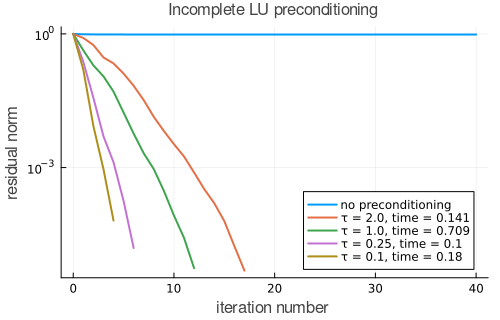

In [6]:
plt = plot(0:40, resnorm[1:41] / resnorm[1];
    label="no preconditioning",  legend=:bottomright,
    xaxis=("iteration number"),
    yaxis=(:log10, "residual norm"),
    title="Incomplete LU preconditioning")
for τ in [2, 1, 0.25, 0.1]
    t = @elapsed iLU = ilu(A; τ)
    t += @elapsed _, history = GMRES(A, b, Pl=iLU, maxiter=100,
        reltol=1e-5, log=true)
    resnorm = history[:resnorm]
    label = "τ = $τ, time = $(round(t,digits=3))"
    plot!(0:length(resnorm)-1, resnorm / resnorm[1]; label)
end
plt

In any given problem, it's impossible to know in advance where the right balance lies between fidelity and speed for the preconditioner.